In [1]:
import json, os
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import warnings

### Markowitz portfolio theory

In [2]:
# Retrive stock data
tickers = ['NVDA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'SPOT', 'TSLA', 'JPM', 'GS', 'LMT']
data = yf.download(tickers, period="252d", interval="1d")['Close']

# Compute daily returns and the covariance matrix
daily_rets = data.pct_change().dropna()
mean_ret = daily_rets.mean() * 252  
cov_matrix = (daily_rets.cov() * 252).round(4)
cov_matrix

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOG,GS,JPM,LMT,MSFT,NVDA,SPOT,TSLA
Ticker,,,,,,,,,,
AAPL,0.1060,0.0643,0.0524,0.0591,0.0417,0.0053,0.0406,0.0684,0.0397,0.1117
AMZN,0.0643,0.1220,0.0616,0.0619,0.0446,0.0041,0.0523,0.0975,0.0562,0.1202
GOOG,0.0524,0.0616,0.1044,0.0459,0.0320,0.0005,0.0374,0.0762,0.0380,0.1128
GS,0.0591,0.0619,0.0459,0.0944,0.0629,0.0086,0.0412,0.0860,0.0555,0.1084
JPM,0.0417,0.0446,0.0320,0.0629,0.0569,0.0082,0.0294,0.0559,0.0369,0.0781
LMT,0.0053,0.0041,0.0005,0.0086,0.0082,0.0688,0.0022,-0.0035,0.0020,0.0106
MSFT,0.0406,0.0523,0.0374,0.0412,0.0294,0.0022,0.0585,0.0758,0.0392,0.0777
NVDA,0.0684,0.0975,0.0762,0.0860,0.0559,-0.0035,0.0758,0.2482,0.0848,0.1587
SPOT,0.0397,0.0562,0.0380,0.0555,0.0369,0.0020,0.0392,0.0848,0.2053,0.0946


### Plotting the efficiency frontier

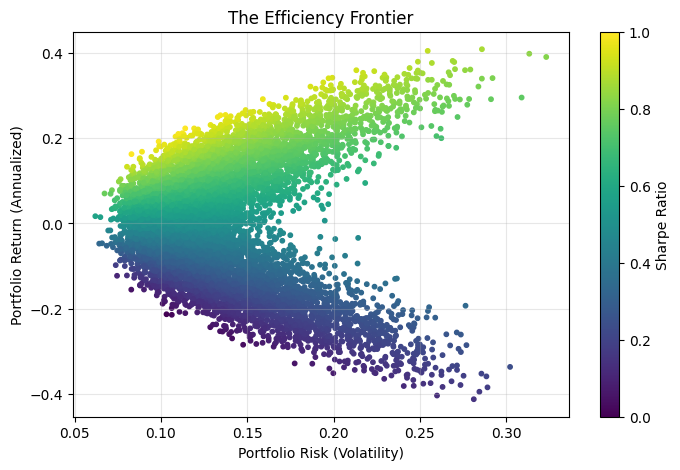

In [3]:
pfolio_ret = []
pfolio_risk = []
pfolio_sharpe = []

for _ in range(10000):
    weights = np.random.uniform(-1, 1, daily_rets.shape[1])  # allow shorts
    weights /= np.sum(np.abs(weights))  # normalize absolute weights

    # compute the portfolio risk, return and the sharpe ratio
    port_ret = np.dot(weights.T, mean_ret)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_ret / port_risk
    
    pfolio_ret.append(port_ret)
    pfolio_risk.append(port_risk)
    pfolio_sharpe.append(sharpe)

colormap = plt.get_cmap("viridis")
norm = matplotlib.colors.Normalize(vmin=min(pfolio_sharpe), vmax=max(pfolio_sharpe))

plt.figure(figsize=(8,5))
plt.scatter(pfolio_risk, pfolio_ret, c=colormap(norm(pfolio_sharpe)), s=10)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Portfolio Risk (Volatility)")
plt.ylabel("Portfolio Return (Annualized)")
plt.title("The Efficiency Frontier")
plt.grid(True, alpha=0.3)
plt.show()

### Computing the optimal weights

In [4]:
mu = daily_rets.mean().values
cov = daily_rets.cov().values           
cov += 1e-5 * np.eye(len(cov))             

# compute the portfolio weights (shorts allowed)
n = len(mu)
ones = np.ones(n)
inv_cov = np.linalg.inv(cov)
weights = inv_cov @ ones / (ones @ inv_cov @ ones)
port_return = weights @ mu                
port_vol = np.sqrt(weights @ cov @ weights)  
annual_return = port_return * 252
annual_vol = port_vol * np.sqrt(252)

# demonstratethe portfolio
portfolio = pd.DataFrame({"Ticker": tickers,"Weights (%)": (weights * 100).round(2)}).set_index("Ticker")
print(f"Expected annualized return: {annual_return * 100:.2f}%")
print(f"Annualized volatility: {annual_vol * 100:.2f}%\n")
display(portfolio)

Expected annualized return: 16.42%
Annualized volatility: 15.81%



,Weights (%)
Ticker,
NVDA,6.29
GOOG,-2.62
AMZN,15.39
AAPL,-15.10
MSFT,39.02
SPOT,31.80
TSLA,33.61
JPM,-5.02
GS,5.08


In [5]:
from datetime import date
today_str = date.today().strftime("%Y-%m-%d")
entry = {
    "date": today_str,
    "weights": {ticker: round(weights[i] * 100, 2) for i, ticker in enumerate(tickers)}
}

output_path = "./payloads/weights.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, "r") as f:
    results = json.load(f)

# remove old entry
results = [r for r in results if r.get("date") != today_str]

# append new entry
results.append(entry)
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)